<a href="https://colab.research.google.com/github/WetSuiteLeiden/example-notebooks/blob/main/datasets/using_dataset_woobesluit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# (only) in colab, run this first to install wetsuite from (the most recent) source. 
#    (this should soon simplify to something like   !pip3 install --upgrade wetsuite)
# For your own setup, see wetsuite's install guidelines.
!pip3 install -U wetsuite

## Purpose of this notebook

Demonstrate a use of the Woo dataset.

Compared to other examples, this one is longer, more involved and creative example, 
though many parts are still fairly basic and manual analysis.

In [1]:
import re, random, collections, pprint

import wetsuite.datasets
import wetsuite.helpers.localdata
import wetsuite.helpers.strings
import wetsuite.helpers.patterns
import wetsuite.helpers.collocation
import wetsuite.helpers.spacy

In [2]:
%matplotlib inline
# ...ensures we show graphs inline later

## Load datasets

In [4]:
# This is a dataset provided by wetsuite 
#   (this separates out some prep work - which will probably also be published once the dataset is cleaner) 
#
#  The Dataset object has 
#  - a .description that explains some basic use,
#  - a .data that should have just been described

# we split up the metadata from the text, because the text is larger.
woo_metadata_store  = wetsuite.datasets.load('woo_besluiten_meta', force_refetch=False)
woo_metadata        = woo_metadata_store.data         # case -> metadata  
print( woo_metadata_store.description )



This dataset tries to focus on the reactions to Woo requests.

its .data is a a map 
- from an unique case identifier (currently happens to be the case's URL on the website, looks like 'https://www.rijksoverheid.nl/documenten/woo-besluiten/2023/08/31/besluit-op-woo-verzoek-geen-documenten-over-gewasbeschermingsregistratie')
- to a dict like:
    {'detail_page_url':       'https://www.rijksoverheid.nl/documenten/woo-besluiten/2023/08/31/besluit-op-woo-verzoek-geen-documenten-over-gewasbeschermingsregistratie',
     'title':                 'Besluit op Woo-verzoek geen documenten over gewasbeschermingsregistratie',
     'response_document_url': 'https://open.overheid.nl/documenten/ef04ac22-1eb9-4b5c-a439-39fb3b636fdf/file',
     'attachments':           [],
     'dates':                 ['2023-08-31'],
     'onderwerpen':           ['Bestrijdingsmiddelen'],
     'responsible':           'Ministerie van Landbouw, Natuur en Voedselkwaliteit'
    }

You are proably also interested in wets

In [ ]:
# we are indeed interested in that text, so...
woo_linked_docs_txt_store  = wetsuite.datasets.load('woo_besluiten_docs_text', force_refetch=False)
woo_linked_docs_txt        = woo_linked_docs_txt_store.data  # url -> text
print( woo_linked_docs_txt_store.description )


This dataset tries to focus on the reactions to Woo requests.
                                                     
You will probably want the Woo metadata dataset first.
It will have `response_document_url` keys linking to a PDF document.

This is a map from that URL to the a plaintext string of the text that PDF contains.
                              
Notes:
- if we figure it was something other than a decision, it may not be present
- the extraction is currenty 'the text the PDF itself reports'
    
Both could use some refinement.   TODO: clean up both the woo metadata and woo text datasets



## Inspect what's in the metadata

In [6]:
# we use pandas to more easily see that metadata as a table
#   as the .description mentions, that's .data's .values() is a list of dicts,
# Pandas happens to be able to treat a dict as tabular-like data without much assistance. 
# We still need some assistance to clean up
import pandas

# we would like a subset of those fields, and in a sensible order,   so we specify what we ant  (it would work without that)
df = pandas.DataFrame( woo_metadata.values(),   columns=['dates', 'title', 'responsible', 'onderwerpen', 'response_document_url', ] ) 

# a little cleanup and massage 
df['dates']  = [min(l) for l in df['dates']]                         # earliest date mentioned (TODO: check)
df['dt'] = pandas.to_datetime( df['dates'] )                         # as python datetime style object
df['onderwerpen']    = [', '.join(map(str, l)) for l in df['onderwerpen']]   # list to string -  there's probably a better way to do that

df.sort_values( ['responsible','onderwerpen'] ) # sort by responsible first, and for the same value of that, sort by onderwerpen. It might still make inspectiona a little more meaningful, but don't expect too much from that.

pandas.set_option('display.min_rows', 10) # increase to show more
display( df )

,dates,title,responsible,onderwerpen,response_document_url,dt
0,2022-06-22,Besluit op Wob-verzoek inzake Taskforce IND,Ministerie van Justitie en Veiligheid,,https://open.overheid.nl/repository/ronl-439df...,2022-06-22
1,2022-01-09,Besluit op Woo-verzoek over de aan de NPO verl...,Ministerie van Economische Zaken en Klimaat,Media en publieke omroep,https://www.rijksoverheid.nl/binaries/rijksove...,2022-01-09
2,2022-09-26,Besluit op Woo-verzoek over mutatie BRIN-numme...,"Ministerie van Onderwijs, Cultuur en Wetenschap",,https://open.overheid.nl/repository/ronl-9f647...,2022-09-26
3,2023-10-05,Besluit Woo-verzoek neveninkomsten ambtenaren,"Ministerie van Volksgezondheid, Welzijn en Sport",Overheidspersoneel,https://open.overheid.nl/documenten/0196d126-5...,2023-10-05
4,2023-08-05,Besluit Woo-verzoek diertellingen Harskamp,"Ministerie van Landbouw, Natuur en Voedselkwal...",Veehouderij,https://open.overheid.nl/documenten/1af046a5-6...,2023-08-05
...,...,...,...,...,...,...
2537,2023-12-10,Besluit op Woo-verzoek over Uromastyx acanthinura,"Ministerie van Landbouw, Natuur en Voedselkwal...",,https://open.overheid.nl/documenten/8eff5fdc-a...,2023-12-10
2538,2023-12-10,Tweede deelbesluit op Woo-verzoek over corresp...,Ministerie van Justitie en Veiligheid,Adoptie,https://open.overheid.nl/documenten/655e1abd-d...,2023-12-10
2539,2023-10-13,Besluit op Wob-Woo-verzoek over Passende Beoor...,Ministerie van Infrastructuur en Waterstaat,"Landelijk gebied: aanpak stikstof, natuur, wat...",https://open.overheid.nl/documenten/21b6fc04-a...,2023-10-13
2540,2023-01-27,Inventarislijst bij Woo over gasleveringen gas...,Ministerie van Economische Zaken en Klimaat,Bodem en ondergrond,https://open.overheid.nl/documenten/d4ad7754-0...,2023-01-27


The following gets a little into data massaging, which is a separate topic.

But it's only to do some inspection, so you can just look at the results.

In [10]:
df['responsible'].value_counts()

responsible
Ministerie van Landbouw, Natuur en Voedselkwaliteit         605
Ministerie van Financiën                                    327
Ministerie van Infrastructuur en Waterstaat                 301
Ministerie van Justitie en Veiligheid                       254
Ministerie van Economische Zaken en Klimaat                 200
Ministerie van Volksgezondheid, Welzijn en Sport            189
Ministerie van Binnenlandse Zaken en Koninkrijksrelaties    179
Ministerie van Buitenlandse Zaken                           109
Ministerie van Onderwijs, Cultuur en Wetenschap             106
Ministerie van Defensie                                      95
Ministerie van Sociale Zaken en Werkgelegenheid              86
Ministerie van Algemene Zaken                                81
Name: count, dtype: int64

In [12]:
pandas.set_option('display.min_rows', 30)
df['onderwerpen_trunc']    = [ onds[:50]   for onds in df['onderwerpen']]  #truncate the strings so that thw eideness doesn't make the counts fall off the screen
df['onderwerpen_trunc'].value_counts()

onderwerpen_trunc
                                                      382
Dierenwelzijn                                         129
Veehouderij                                           105
Natuur en biodiversiteit                               69
Luchtvaart                                             52
Belasting betalen                                      50
Bodem en ondergrond                                    35
Kwaliteit en integriteit overheidsinstanties           35
Kinderopvangtoeslag                                    31
Mest                                                   31
Duurzame energie                                       29
Rijksoverheid                                          28
Scheepvaart en havens                                  25
Coronavirus: financiële regelingen                     24
Coronavirus COVID-19                                   24
                                                     ... 
1e Deelbesluit op Wob-/Woo-verzoek over presentati    

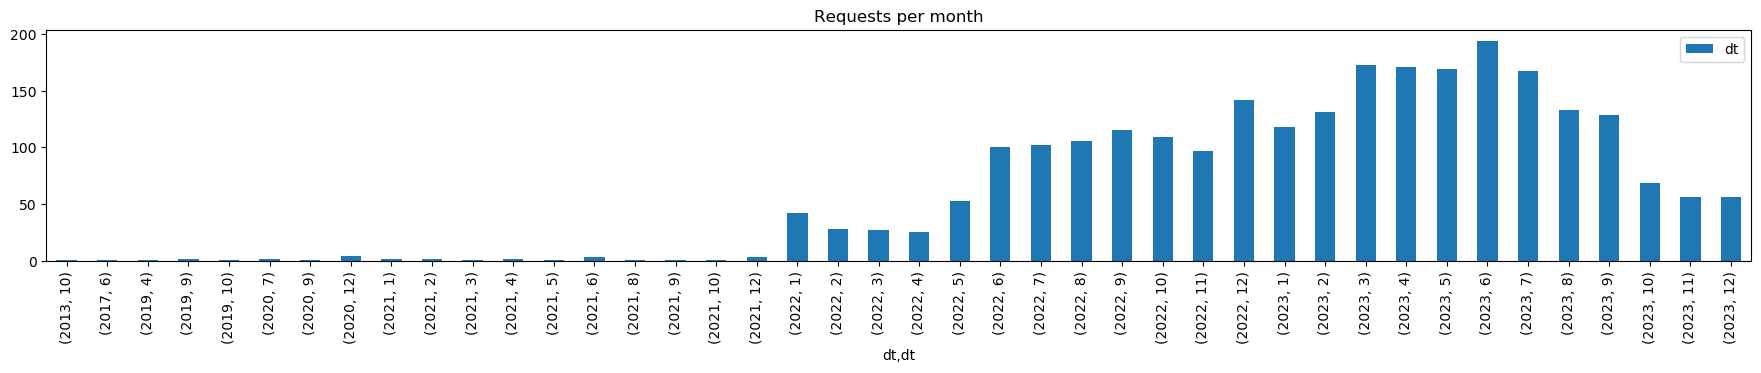

In [10]:
# slightly magical pandas syntax  to get a count per month
# Note: this is not a proper date axis so the positining is wrong, but it gets a basic idea across
tt = df[ ['dt'] ].groupby( [df["dt"].dt.year,df["dt"].dt.month] ).count().plot(kind="bar", figsize=(22,3), title='Requests per month', stacked=True)

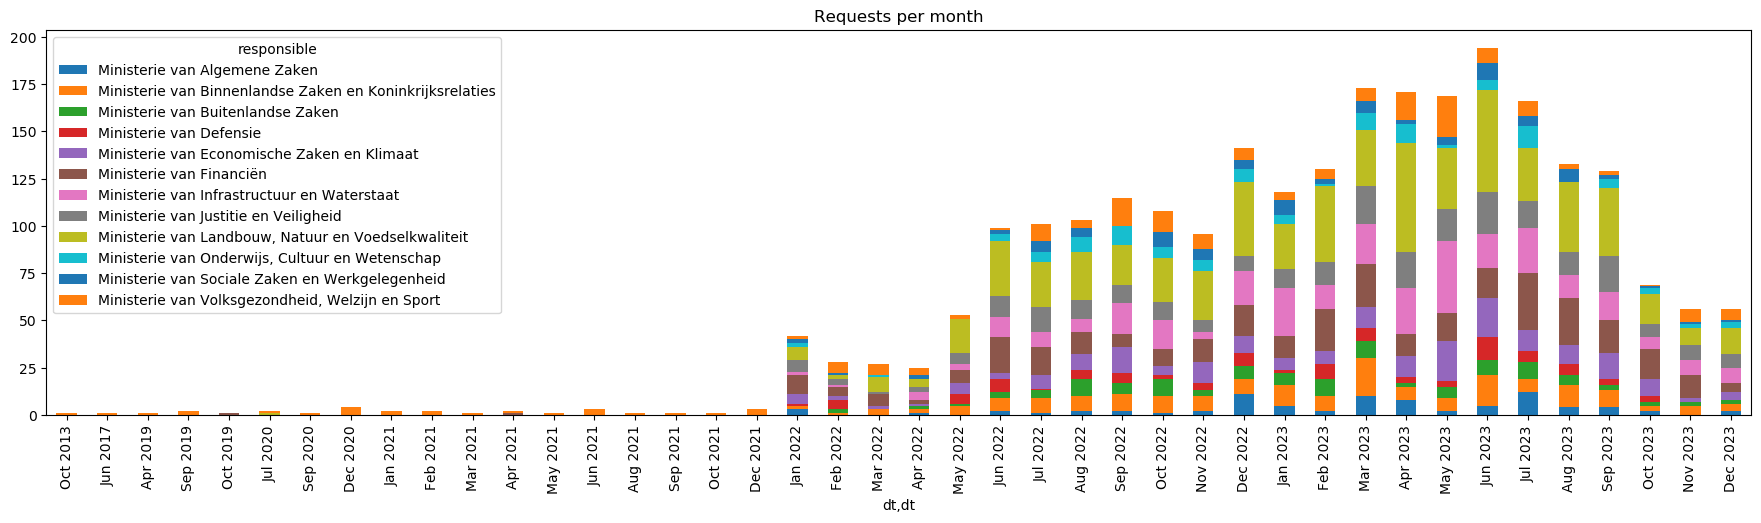

In [11]:
# _definitely_ magical pandas syntax  to plot that per responsible ministery
#   (note: still not a proper linear date axis, but has nicer labels, we just pretend it's not a little wrong)
tt = df[ 'dt' ]  .groupby( [df["dt"].dt.year,df["dt"].dt.month,df['responsible']] ).count().unstack(level=-1)

# the following lines are to make the x labeling nicer, you could stick the .plot part on the previous line and be done with it
import matplotlib.ticker
month_name = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
ax = tt.plot(kind="bar", figsize=(22,5), title='Requests per month', stacked=True)
ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter( list( '%s %s'%(month_name[m],y)  for y,m in tt.index[:]) ))
ax

## Start working with the text

Let's look at some documents. For now completely outside of the context of that structure / metadata.

In [6]:
# A list of strings document text content
txtdocs = list( woo_linked_docs_txt.values() )   # (explicit list() to fetch all from a view)
len(txtdocs) # show how many we have

2339

In [8]:
# pring text content of one random document
print( random.choice( txtdocs ) )
# probably do that a few times to inspect the sort of text we have

> Retouradres Postbus 90801 2509 LV Den Haag
Directie Wetgeving,
Bestuurlijke en Juridische
Aangelegenheden
Postbus 90801
2509 LV Den Haag
Parnassusplein 5
T 070 333 44 44
www.rijksoverheid.nl
Contactpersoon
T 
PostbusWBJAWoo@minszw.nl
Datum: 22 februari 2023
Onderwerp: Besluit
Onze referentie
WBJA-Woo/4.2022.1294.001 
Uw referentie
Geachte heer/mevrouw,
Bijlagen
-
In uw verzoek van 9 november 2022, door mij ontvangen op eveneens 9 
november 2022 heeft u namens elf ondernemingen het ministerie van Sociale 
Zaken en Werkgelegenheid (hierna: SZW) gevraagd om informatie openbaar te 
maken waaruit blijkt dat voorafgaand aan de algemeenverbindendverklaring van 
bepalingen van bepalingen van de collectieve arbeidsovereenkomsten (hierna: 
cao)  Bouw & Infra en BTER respectievelijk aan de totstandkoming van de 
verplichtstellingsbeschikking respectievelijk wijzigingen daarin, steeds sprake was 
van voldoende representativiteit. Ook heeft u aangegeven dat uw verzoek 
betrekking heeft op openbaa

Once you run the above a few times, it becomes clear that the text content of those PDFs is varied.

* It seems that sometimes it's all of the attached content documments as well, which is itself messy text. 
  Right now we choose to care more about the initial letter motivating the decision of what to release.

* Some of them have _somewhat_ garbled text, see e.g.
  `print( woo_linked_docs_txt.get('https://open.overheid.nl/documenten/a86654da-9ffa-4ac3-a9f2-1952022fc131/file') )` here seemingly OCR having trouble because the document is actually a low-quality iamge of the actual document.  
* Some are entirely garbled, for reasons like that [it's rotated](https://open.overheid.nl/documenten/0fb70d64-60bc-401b-9940-5e6d0cf8434b/file) and the OCR didn't notice. 

* Also, you'll notice the headers and footer text is often interspersed in the document. 
  This is technically complete, but might hinder interpretation when that was in the middle of a paragraph.

Fixing the last two mentioned problems should probably be done earlier in the process, while creating the dataset. 
Refining the quality of PDF extraction is not currently top of our list, so please contact us if you do actually care for this cleanup.
For now, we work with what we have.

That's just the lower level stuff. At a higher level, you have the issue that

* With how the website works right now, not every item is a case. 
  This is probably something we should fix while _making_ the dataset, not while _using_ it.

<!-- -->

The below ends up assuming each item is probably a case -- and in checking them for the right text,
it just reject some outright. It would be better to check that and fix that, rather than just silently forget a percentage of t.

We might be missing cases and we want to _know_ that, so TODO: be stricter about that.

<!--
How relevant is it if there's an attached ['relevant parts from the law'](https://open.overheid.nl/documenten/a361527e-9843-4eac-841b-335be4b0e2dd/file), etc
-->

We might want to see if we can find the headers in that letter,
in case they are following a strict template and we can easily focus on its parts.

## Try to fish out mainly the de decision's body

If we can clean up our text data earlier, we can make life easier for ourselves later in the process.

When we mainly care for the argument that is the motivation, then we might like to:

* ensure the document contains a besluit

* cut off all the text that isn't a besluit
    - see if we can can reliably cut off the cover page,
    - see if we can cut off everything after the motivation's signoff, because if anything follows it's probably a lot of attached content.

OPTIONAL EXTRA COMPLEXITY: While we're doing that, let's also see if we can ''determine'' the various section headers - 
shortish titles like "Uw verzoek", "Wettelijk kader", "Besluit", by counting phrases that are on their own line. 

The cleaning code benefits from knowing that, so the code below is actually the result of a few iterations
of determining and then hardcoding such text.

In [17]:
def seems_like_besluit(text):
    ''' Takes text that is the entire document of text,
        returns whether it looks like it contains a besluit?  

        Mainly used to note cases we may want to inspect.

        A very simple estimation, that uses common header substrings as indicators.
           and misses a few cases, e.g. https://open.overheid.nl/documenten/bc3ec39d-f442-4ba3-b14d-929f2c0a6eb0/file
    '''
    # see if we find some common headers, alone on a line
    stronger_count, weaker_count = 0, 0

    for header_pattern in (
        # Look for common headers - should be relatively strong indicator
        'Wettelijk kader',
        'Zienswijze derde-belanghebbende',
        'Zienswijzen',
        'Overwegingen',
        'Beoordeling van uw verzoek',
        'Behandeling van het verzoek',
        'Besluit',
        'Beslissing',
        'Motivering',
        'Verloop van de procedure',
        'Gronden van bezwaar',
        'Gronden van het bezwaar',
        'Relevante jurisprudentie',
        'Relevante wetsartikelen/juridisch kader',
        'Beoordeling van het bezwaar',
        'Inventarisatie documenten',  
        'Wijze van openbaarmaking',
    ):
        if re.search(r'\n[0-9\s.]*%s:?[\t\ ]*\n'%header_pattern, text, flags=re.M|re.I) is not None:
            stronger_count += 1

    for other_pattern in ( # look for some weaker patterns - potentially endless, so mostly focus on ones that may still be there in short responses that don't have the above
        'uw verzoek van ',
        'niet inwilligen',
        'u vragen heeft',
    ):
        if re.search(r'\b%s\b'%other_pattern, text, flags=re.M|re.I) is not None:
            weaker_count += 1

    #print( stronger_count, weaker_count)
    return (stronger_count*2 + weaker_count) >= 4

In [ ]:
### Given the above, this is doing two independent things at once    (CONSIDER: splitting that up)
simpler_bodies = {}  # THE MAIN THING we're making right now:  doc_url -> output of that remove-stuff-other-than-the-body
count_lines    = []  # THE OTHER THING:  counting of lines to see if that gives us some section headers just by merit of repetition

count_besluiten, count_nonbesluiten = 0,0   # ...also, see how many documents seems_like_besluit() figures are besluiten.


for doc_url, doc_text in woo_linked_docs_txt.items():  # Go through all cases
    print('\n\n')
    print('-=------ %s ------=-'%doc_url)

    # If there are _many_ empty lines in a row, reduce that  (CONSIDER: doing that in the dataset step so we can remove that here)
    doc_text = re.sub(r'(\n[\t\ ]*){4,}', r'\n\n', doc_text, flags=re.M)  # regexp magic, apologies

    # check if there's any text at all
    if len(doc_text.strip()) < 10:
        print("  Contained no text")
        continue
    
    
    ### Try to remove text before the intro and after the signoff
    start_cutoff = 0
    end_cutoff   = len( doc_text )
    # CONSIDER: we could in theory keep track of the list of indices so we can keep track of *why* we removed, for easier debug when this breaks    


    ## Try to remove everything initial header
    remove_everything_before = ('Geachte',)    # CONSIDER: only if on first pages
    for remove_before in remove_everything_before:
        if remove_before in doc_text:
            pos = doc_text.find(remove_before)
            if pos < 2000: # if it's not on the first pages, it may be something else, so ignore it
                start_cutoff = max( start_cutoff, pos+len(remove_before) )
            print('FOUND %r, moved start_cutoff up to %d'%(remove_before, start_cutoff))


    ## Try to remove cases where the documents are also in there   by finding the end end of the decision document 
    remove_everything_after = ('Met vriendelijke groet', 'Hoogachtend,',  # this is crude but reasonably effective
                               'Plaatsing op Internet',
                               #'Meer informatie', 'namens deze,',  # less effective
                              )
    for remove_after in remove_everything_after:
        if remove_after in doc_text:
            end_cutoff = min( end_cutoff, doc_text.find(remove_after) )
            print('FOUND %r, moved end_cutoff down to %d'%(remove_after, end_cutoff))

    before, main, after = doc_text[:start_cutoff], doc_text[start_cutoff:end_cutoff], doc_text[end_cutoff:]


    # If this is a besluit, we should now be focusing on its body
    ## Actually check that it is a besluit
    if seems_like_besluit( main ):
        count_besluiten += 1
        print("  Okay as response document")

        #if len(main) > 25000: # that's probably more than the besluit, see if there's anything to cut off by
        #    print( 'LONG (%s)'%len(main),  main)
    else:
        count_nonbesluiten += 1
        print("  ...doesn't seem like response document  OR  we removed too much")
        if 0:  # in debug, show what we have and what we removed, in case we need to correct it
            for line in before.splitlines():
                print('REMOVED BEFORE   ', line)
            for line in main.splitlines():
                print('LEFT BODY        ', line)
            for line in after.splitlines():
                print('REMOVED AFTER    ', line)
        continue


    ## The main output: if it seems like a besluit, put in dict of such
    simpler_bodies[doc_url] = main


    ## The other output, the experiment trying to see if we can find the headers
    # Try to match phrases after an empty line (that will _not_ be true from each document, but with enough data this might be cleaner)
    #for match in re.finditer(r'\n\n((?:[0-9]+[.]? )?[A-Za-z0-9/]{4,65})[\ ]*\n', doc_text, re.M):
    #    match_text = match.group(1).strip()
    templines = []
    for line in main.splitlines(): # add lines unless we know they're not interesting
        line = line.strip(' \ufffd')
        if len(line) <= 5:
            continue
        line = re.sub('^[0-9][.] ','', line)
        match_text = line
        if re.match(r'5[. ]1[. ]2[. ]?[a-zA-Z]\s*$', match_text) is not None:
            continue
        if re.match(r'[0-9 ]{1,8}\s*$', match_text) is not None:
            continue
        if match_text in ('Datum', 'Ons kenmerk'): 
            continue
        templines.append( match_text )

    count_lines.extend( templines )

In [19]:
print(f"Of our {len(woo_linked_docs_txt)} apparently cases, {count_besluiten} seem to have besluiten, and {count_nonbesluiten} seem not to  (TODO: sift through them better; TODO: ability to count)")

Of our 2339 apparently cases, 1943 seem to have besluiten, and 325 seem not to  (TODO: sift through them better; TODO: ability to count)


Go through the experiment's data:

See what kind of complete lines are common -- because things with high counts tend to be few-word things that are headers.

We could do this with collections.Counter (which is standard library), but this way gets us case-insensivtive counting.

In [20]:
lc = list( wetsuite.helpers.strings.count_normalized( count_lines,  normalize_func=lambda s:s.lower() ).items() )
lc.sort(key = lambda l:l[1], reverse=True)
for line, count in lc[:100]:
    if len(line) < 50:
        print('%5d  %s'%(count, line))
#pprint.pprint( count_lines.most_common( 50 ) )

12745  Retail
11116  RESULTAAT
 7075  Import
 5494  OWHH11 Residuen AGF (CB)
 5004  27,6667
 4308  I6KI05A IMPORT FOOD - Residuen (CB)
 4231  Nederland
 2644  59,3385
 2636  48,1515
 2616  45,6515
 2304  OWHH14B Supermarkt Survey Winter (CB)
 2153  OWHH15C IMPORT residuen (CB)
 1974  openbaar
 1950  0260010-004 sperziebonen/snijbonen
 1862  Besluit
 1852  Onze referentie
 1728  Wettelijk kader
 1728  Spanje
 1667  Deels openbaar
 1610  Landcode onbekend
 1425  143,8067
 1375  OWHH14A Supermarkt Survey Zomer (CB)
 1372  5,0764
 1297  Inventarisatie documenten
 1190  Overwegingen
 1136  48,7079
 1127  0151010 tafeldruiven
  892  Gedeeltelijk
  856  27,6053
  843  Vragen
  840  0110020 sinaasappelen
  823  Zuid Afrika
  812  Juridische Zaken
  791  0401020 pindas/aardnoten
  784  Vietnam
  780  Directie Juridische Zaken
  776  OWHH11FU Residuen Follow-Up (CB)
  760  De eerbiediging van de persoonlijke levenssfeer
  749  doc 21
  719  Brazilie
  695  OWHH11VOL Residuen Volumeproducten (CB)

## Test with the main, text output: pick out the most interesting sections, and inspect

OPTIONAL EXTRA COMPLEXITY: let's see what kind of language is being used in the arguments,
by coloring each sentence by what function they serve in the argument.
This is way too crude to use for actual analysis, but useful to inspect some text faster.

In [21]:
# This is the just-mentioned coloring code.  
# _Very_ basic.

def blend_rgbs(rgblist):
    ll = len(rgblist)
    rs = list(float(rgb[0])  for rgb in rgblist)
    gs = list(float(rgb[1])  for rgb in rgblist)
    bs = list(float(rgb[2])  for rgb in rgblist)
    return int(sum(rs)/ll), int(sum(gs)/ll), int(sum(bs)/ll)


def sentence_flavours_css(sent_text, flavours, cssvar="color"):
    ''' Takes a string, returns a css style based on present patterns (currently mostly substrings) 
        Reads _how_ to color from the flavours variable
    '''
    rgbs = []
    for flavour_abbrev, (rgb, match_expressions) in flavours.items():
        for match_re in match_expressions:
            if re.search(match_re, sent_text, flags=re.I):
                rgbs.append( rgb )
    if len(rgbs) > 0:
        r,g,b = blend_rgbs( rgbs )
        return '%s: #%02x%02x%02x'%(cssvar, r,g,b)
    else:
        return ''


class ColorSentences:
    ''' This is some magic that works in jupyter/ipython/colab notebooks.

        Takes
        - a list of strings,  
        - a structure that says what colors to assign when a pattern matches 
        Per sentence will detect that, and blend colors if mltiple match,
        Returns 
        - an object that notebooks will render (via HTML) where each string is colored with that blend.
    '''
    def __init__(self, sentence_list):
        self.sentence_list = sentence_list
        #global flavours
        #self.flavours      = flavours
    def _repr_html_(self):
        ret=['<div class="sents" style="background:#000">']
        for sentence_text in self.sentence_list:
            #style = sentence_flavours_css( sentence_text, self.flavours )
            style = sentence_flavours_css( sentence_text, flavours )
            ret.append('\n <div class="sent" style="%s; padding-bottom:0.3em; display:inline">'%style)
            #wetsuite.helpers.spacy
            ret.append( #style +
                        sentence_text )
            ret.append('</div>')
        ret.append('</div>')
        return ''.join(ret)


flavours = {
    'INTRO':((0,200,50),[ # GREEN
        "verzoek gaat over",
        "wijzen op",
        "het volgende",
        "heeft het recht",
        "Wet open overheid",
        "eenieder",
        "belangrijk recht",
        "recht op openbaarheid",
        "staan in",
        "kunt u lezen",
        "uitgangspunt",
        "gelet op bovenstaande",
        "n het algemeen",
        "om te beslissen",
        "inventarislijst",
        "om te beslissen",
        "per alinea",
        "nader toe",        
        'licht ik',
        'verder toe',

        'bezwaar gemaakt',
    ]),

    # relatively factual - relevance, detailing
    'SPEELTMEE':((200,200,50),[  # YELLOW
        'relevante artikelen', # arguably intro
        "artikel ", #TODO: based on extracted references
        "vraagt u",
        "op grond",
        "geen grond",
        "staan in",
        "staat in",
        "belang van",
        "gelet op",
        "dit begrip",
        "geen verplichting",
        "in overweging",
        'betreft onder andere',
        "worden aangemerkt",
        "ouder dan",
        "beoogt ",
        "beoogd ",
        "motiveren waarom",
        "mogelijk gevolg",
        "uitzonderingsgrond",
        "kan besluiten",
        "openbaarmakingsregeling",
        #"soort uitzonderingsgrond"
        #"absolute uitzonderingsgrond",
        #"van belang",
        "ingeschat",
        "motivering",
        "betreft informatie",
        "al openbaar",
        "bestaande informatie",
        "zijn beschikking",
        'met inachtneming',

        'bijvoorbeeld',
    ]),

    # possibly-more-subjective considerations?
    'AFWEGING':((200,150,50),[ # ORANGE
        "weegt mee",
        "belangenafweging",
        "afweging",
        "gevoelige informatie",

        'prevaleert',
        'in afwijking',
        "uitzonderingsgronden",
        "in de zin van",
        "buiten toepassing", 
        'buiten de reikwijdte',
        "wijken",
        'schenden',
        "reikwijdte",
        "mogelijk",
        "het geval",
        "intern beraad",
        "beleidsopvattingen",
        "concurrentiegevoelig",
        "betrokken",
        "verwijs ik",
        "naar de uitspraak",
        "geheimhoudingsbepaling",
        
        'belang van',
        #'sprake van',
        'zwaarder moet wegen',
        'zwaarder weegt',
        'weegt zwaarder',

        "ter bescherming",
        "vertrouwelijk aan de overheid",
        "geheimhoudingsplicht",
        "persoonlijke levenssfeer",
        "persoonsgegevens",
        "te herleiden zijn",
        "herleidbaar zijn",
        "tot een persoon",

        "risico op",
        "belangen van de staat",
        "goed functioneren van de Staat",
        "diplomatiek verkeer", 
        'diplomatieke verkeer',
        'internationale',

    ]),
    'PRESUP':((200,50,200),[ # purple
        'vind ik', 
        'acht ik',
        "niet wenselijk", 
        "onwenselijk",
        'kan schenden',
        "potentiele hinder",
        'groter belang',
        "Ik voorzie "
        "kunnen leiden",
        "kan er toe leiden",
        "kan ertoe leiden",
        "kans aanwezig",
        "geen meerwaarde",
        "goed functioneren",
        "andere doeleinden",
        "acht het belangrijk",
        "in gevaar brengen",
    ]),
    'CONCRETE':((200,0,0),[  # RED
        #"daarom ",
        #"hierom ",
        
        # active voice tends to
        "Ik maak ",
        'maak ik ',
        'maak ik .*niet openbaar',
        'Ik heb besloten',
        "heb besloten",
        'ben van oordeel'
        'ik openbaar',
        "Mijn conclusie",
        "afwijs",
        "Ik wijs uw",
        "is afgewezen",
        "niet inwilligen",
        #"openbaar te maken",
        #"geformuleerd", # 
        #"niet openbaar",

        "niet openbaren",
        "in het geheel niet",
        "niet openbaar te maken",
        "gedeeltelijk openbaar te maken",
        #"openbaar gemaakt", # passive
        "niet van toepassing",
        "deels gehonoreerd",

        "niet geregistreerd", # afweging?
        "niet aangetroffen",

        "geweigerde stukken",
        "afgeschermd",
        "onleesbaar",
    ]),
    # maybe separate out practicalities?
}

In [25]:
for case_uniq, entry_metadata in random.sample( woo_metadata.items(), 3 ): # for a handful of cases (mostly for quick debug to )
#for case_uniq, entry_metadata in woo_metadata.items():
    response_document_url = entry_metadata['response_document_url']
    if response_document_url in simpler_bodies: # only ones we've accepted as being decision documents
        body = simpler_bodies[response_document_url]

        print( '\n\n\n=== %s ========================================='%entry_metadata['title'] )
        print( "Case detail page:      ", entry_metadata['detail_page_url'] ) 
        print( "Probably response doc: ", response_document_url ) 


        ### SPLIT DOCUMENT into functional sections by paragraph-header-like things
        # Not to present it as a document split into neat semantic parts,
        #     (note that there is no single template being used to these documents, so doing that cleanly would often be a little incomplete anyway)
        #
        # ...but to be consider smaller chunks of text for whether it is interesting to include,
        #    probably based on relevant/interesting fragments of language
        #
        # (As to the code, it should probably become more readable logic, rather than some magic regexps and assumptions)

        look_for_headers = ( # hardcoded, partly based on the "find headers" from earlier
            r'Uw verzoek\s*',
            r'Wettelijk kader\s*',
            r'Relevante wetsartikelen/juridisch kader\s*',
            r'Gronden van bezwaar\s*',
            r'Relevante jurisprudentie\s*',
            r'Beoordeling van uw verzoek\s*',
            r'Beoordeling van het bezwaar',
            r'Inventarisatie documenten\s*',
            r'Aangetroffen documenten\s*',
            r'Dwangsom\s*',
            r'Procedure\s*',
            r'Zienswijzen\s*',
            r'Overwegingen\s*',
            r'Besluit\s*',
            r'Toelichting\s*',
            r'Geen derde-belanghebbenden\s*',
            r'Verloop van de procedure\s*',
            r'Hoe wordt het document openbaar gemaakt?\s*',
            r'Wijze van openbaarmaking\s*',
            r'Wijze van openbaarmaking en publicatie\s*',
            r'Plaatsing op internet\s*',
            r'Afschrift aan belanghebbende\s*',
            r'Bezwaar\s*',
            r'Bezwaarclausule\s*',
            r'Vragen\s*',
            r'Meer informatie\s*',
        )

        # quite hackish right now. TODO: clean up
        rr = r'(?:[0-9]+[.]\s*)?(%s)'%('|'.join(look_for_headers))   # some documents number their headers, some do not
        re_alone = r'(?:^|\n)%s\n'%rr                                # alone on a line?
        tt = re.split( re_alone, body, flags=re.M|re.I ) 
        tt.pop(0) # not really correct?
    
        #relevant = collections.OrderedDict() # headername -> text

        while True:

            # go through these seeming sections,
            if len(tt)>=2:
                title = tt.pop(0).strip()
                part_test  = tt.pop(0)

                # Decide whether this section has content of interest to us -- either article references or an interesting title  (TODO: improve)
                refs = wetsuite.helpers.patterns.find_references( part_test )
                if len(refs) > 0 or wetsuite.helpers.strings.contains_any_of(title.lower(), [#'wettelijk kader',
                                                                                             'besluit', 'beslissing','toelichting'] ): # only include sections that refer to laws, because that's a decent filter to the arguments.
                    # seems interesting to report,
                    print('    --- %s ----'%title)
                    sents = wetsuite.helpers.spacy.sentence_split( part_test, as_plain_sents=True )

                    # print colored sentences,
                    display( ColorSentences( sents ) )

                    # print detected references.
                    refs = []
                    for sent in sents:
                        refs.extend( wetsuite.helpers.patterns.find_references( sent ) )
                    
                    if len(refs) > 0:
                        for ref in refs:
                            print('    REFERENCE: '+wetsuite.helpers.strings.simplify_whitespace(ref['text']))
                        print()
                        print()

                #print( '\n'.join( textwrap.wrap( text, initial_indent='    ', subsequent_indent='    ')) )
                
            if len(tt)<2:
                #if len(tt)==1:
                break




=== Besluit op Wob-/Woo-verzoek over meldingen, handhavings- en inspectierapporten specifieke dierentuin =========================================
Case detail page:       https://www.rijksoverheid.nl/documenten/woo-besluiten/2023/03/14/besluit-op-wob-woo-verzoek-over-meldingen-handhavings--en-inspectierapporten-specifieke-dierentuin
Probably response doc:  https://www.rijksoverheid.nl/binaries/rijksoverheid/documenten/woo-besluiten/2023/03/14/besluit-op-wob-woo-verzoek-over-meldingen-handhavings--en-inspectierapporten-specifieke-dierentuin/Besluit+op+Wob-Woo-verzoek+over+meldingen%2C+handhavings-+en+inspectierapporten+specifieke+dierentuin.pdf
    --- Wettelijk kader ----


    REFERENCE: artikel 10.1. Woo


    --- Besluit ----


    --- Overwegingen ----


    REFERENCE: artikel 1.1 van de Woo
    REFERENCE: artikel 5.1, eerste lid, aanhef en onder c, van de Woo
    REFERENCE: artikel 5.1, tweede lid, aanhef en onder e, van de Woo
    REFERENCE: artikel 5.1, tweede lid, aanhef en onder f, van de Woo
    REFERENCE: artikel 5.1, eerste lid, aanhef en onder c, van de Woo
    REFERENCE: artikel 5.1, tweede lid, aanhef en onder h, van de Woo
    REFERENCE: artikel 5.1, tweede lid, aanhef en onder i, van de Woo


    --- Wijze van openbaarmaking ----


    REFERENCE: art 4.4, vijfde lid, van de Woo
    REFERENCE: artikel 4.4, vijfde lid, van de Woo





=== Besluit op Woo-verzoek over redenen opschorting en deelbesluiten Woo-verzoeken =========================================
Case detail page:       https://www.rijksoverheid.nl/documenten/woo-besluiten/2022/10/21/besluit-op-woo-verzoek-over-redenen-opschorting-en-deelbesluiten-woo-verzoeken
Probably response doc:  https://open.overheid.nl/repository/ronl-a4ac12bee4fb7f29a123c2b85ec71807ef6cca57/1/pdf/Besluit%20op%20Woo-verzoek%20over%20redenen%20opschorting%20en%20deelbesluiten%20Woo-verzoeken.pdf
    --- Inventarisatie documenten ----


    REFERENCE: artikel 4:15, van de Awb
    REFERENCE: artikel 4.4, derde lid, van de Woo


    --- Besluit ----


    --- Overwegingen ----


    REFERENCE: artikel 1.1. van de Woo
    REFERENCE: artikel 5.1, tweede lid, aanhef en onder e, van de Woo
    REFERENCE: artikel 5.1, tweede lid, aanhef en onder i, van de Woo
    REFERENCE: ECLI:NL:RBDHA:2020:569


    --- Wijze van openbaarmaking en publicatie ----


    REFERENCE: artikel 2.4, derde lid, onder d, van de Woo




## Exceptions and their motivations

Woo besluiten are frequently granted only partially, based on exceptions that apply to specific parts of the requested information.




The exceptions are interesting to study, so now we can for aanwijzingen like
`artikel 5.1, tweede lid, aanhef en onder a, van de Woo`

Note that there will be abbreviated references like
`[...] van andere publiekrechtelijke lichamen of de in artikel 1a, onder c en d, bedoelde bestuursorganen [...]`
(though in that particular case it's not immediately clear to me what that refers to, even with the document's context).


These will be based on [Woo chapter 5](https://wetten.overheid.nl/BWBR0045754#Hoofdstuk5) ("Uitzonderingen").

Roughly speaking,
* 5.1 deals mostly with refusal based on endangering specific concerns
  * 5.1.1 (a through e) are reasons to refuse that, if applicable, easily block information without much weighing against others, reasons roughly like:
    * `5.1.1.a` unity of [the crown](https://nl.wikipedia.org/wiki/Kroon_(regering)) 
    * `5.1.1.b` security of the state
    * `5.1.1.c` information that was given to the government with expectation of confidentally
    * `5.1.1.d` personal information (special cases like sex, politics, union)
    * `5.1.1.e` personal information (BSN and such)
  * 5.1.2 (a through i) are reasons to refuse which, if applicable, are weighed against specific reasons, reasons roughly like:
    * `5.1.2.a` international relations  
    * `5.1.2.b` economic interests of the state
    * `5.1.2.c` ability to resolve illegal acts
    * `5.1.2.d` ability to do inspection/control
    * `5.1.2.e` personal safety (? how does this compare )
    * `5.1.2.f` private interest not covered by 5.1.1.c  (probably asked of company)
    * `5.1.2.g` environmental impact
    * `5.1.2.h` personal and corporate safety
    * `5.1.2.i` general function of the state

Notes
* ...plus note that [article 8.8](https://wetten.overheid.nl/BWBR0045754/#Hoofdstuk8_Artikel8.8) mentions relations to other laws, [mentioned in the bijlage](https://wetten.overheid.nl/BWBR0045754/#Bijlage)

TODO woo wet bijlage -- extra relevante artikelen wetten 


* The resulting motivations are mentioned in the responese, and will be more detailed for that second set.

* There's more to that law, of course. Aside from some more procedural details, there are more articles that limit information, including 5.1.5 which seems to be for exceptional exceptions), but the above are the parts most likely to be cited from a motivation.

* the released documents are anonymized in the documents -- and will frequently be marked with the same codes, probably largely 5.1.2.e, "de eerbiediging van de persoonlijke levenssfeer" used to remove the most personally identifiable information.

* Information may also be released with delay 
  * does that mean detail pages may not be complete just yet so we shouldn't cache them if recent? (VERIFY)

## What if we want to index what kind of arguments what kind of documents make?

As you may have seen above in the "how are the sentences split between introduction, reasoning, and conclusion",
some will succinctly refuse, others use a lot of hedged language and leave the reason for refusal almost to implication
but having a small pile of arguments and then saying no.


Point being that there there may not be a "For piece of information X, rule Y applies because of fact Z"

If it's hard even for humans to interpret, human-made machines with the same instructions will often not do much better.
LLMs are likely to struggle to give a succinct correct answer.

<!-- -->

On the other hand, consider how people would generalize something - 
"this seems to be about X" is often served by a collection of indicators. 

If we show all our work,
maybe characterize a document by counting towards all the possible,
we might 
and give both an estimation to the overall reason _and_ a put a relative certainty to that.

This mix of automatic and verifiable.



On the other side, if what you wanted was a "show me all your work and maybe a good guess",
then we could e.g. yield a list of pieces of evidence for specific reasons




It would be easier to e.g. summarize each section by how much it seems to contributes to one of a number of types of reasoning. 

On one side this may be merely a preprocessing tool, 








Say, it can be very useful to go through the arguments and 







Ik ben van oordeel dat ten aanzien van deze gegevens het belang, dat de persoonlijke levenssfeer wordt geëerbiedigd, zwaarder moet wegen dan het belang van openbaarheid.



patterns reacting to common reasons







IRAC

In [ ]:
import re, wetsuite.helpers.patterns
#re_artlid = re.compile("(([Aa]rt(?:ikel|.|))[,\s]+([0-9:.]+)[,\s]+(.{0,30})lid.{0,100})")
#re_artlid.findall("    artikel 5.1, tweede lid, aanhef en onder a, van de Woo")

re_artlid = re.compile(r"((?:[Aa]rt(?:ikel|[.]|))(?:.|\n){1,100} van (?:.|\n){1,200})(?:.| kan)?", flags=re.M)

teststr = 'Algemene overweging: openbaarheid t.a.v. een ieder  \nAls eerste wil ik u wijzen op het volgende.  \n \nIedereen heeft het recht om overheidsinformatie op te kunnen vragen zonder \ndaarbij een reden te hoeven aangeven. Dit staat in artikel 1.1. van de Woo. Dit is \neen belangrijk recht van de burger. Daarbij is het uitgangspunt dat \noverheidsinformatie openbaar is, tenzij er uitzonderingsgronden zijn die dit \nbeperken. De uitzonderingsgronden staan in hoofdstuk 5 van de Woo. Ik moet \nhierbij het algemeen belang van openbaarheid afwegen tegen de belangen die de \nuitzonderingsgronden beschermen. In het algemeen geldt hierbij de regel dat \nwanneer ik informatie aan u verstrek, het openbaar is voor een ieder. De Woo is \nniet van toepassing op informatie die al openbaar is.  \n \nHet belang van de betrekkingen van Nederland met andere landen en staten en \nmet internationale organisaties \nOp grond van artikel 5.1, tweede lid, aanhef en onder a, van de Woo kan ik geen \ninformatie openbaar maken als dit de relatie van Nederland met andere landen, \nstaten of internationale organisaties beschadigt en dit belang zwaarder weegt dan \nhet belang van openbaarheid.  \n \nDeze uitzonderingsgrond beoogt te voorkomen dat de wettelijke plicht tot het \nverstrekken van informatie tot gevolg zou hebben dat de Nederlandse \ninternationale betrekkingen schade zou lijden.  \n \nHet betreft hier een intern rapport van de Europese Commissie (hierna: EC), meer \nspecifiek een rapport van DG Budget. Deze controlerende instantie maakt \nonderdeel uit van het directoraat-generaal Begroting van de EC, die belast is met \nhet beheer van de EU-begroting. De betrekking van de Nederlandse staat met de \n   \n \n\n  \n   \nEC draagt bij aan de goede werking van de douane-unie, een essentieel verbond \nvan de Europese Unie (EU), waarmee onder meer burgers, dieren en het milieu \nworden beschermd. Daarnaast draagt een goede werking van de douane-unie bij \naan bestrijding tegen de handel in mensen, drugs, wapens en namaakgoederen, \nwitwassen, belastingen ontduiken, financieren van criminele organisaties en fraude \nmet belastingen en heffingen.  \n \nDaar de EC uitdrukkelijk heeft aangegeven niet in te stemmen met \nopenbaarmaking en de Nederlandse staat de betrekking met de EC niet wil \nschaden gezien het belang van het waarborgen van de goede werking van de \nEuropese douane-unie, zal ik deze informatie niet openbaar maken. \n \nDe economische of financiële belangen van de Staat, van andere publiekrechtelijke \nlichamen of de in artikel 1a, onder c en d, bedoelde bestuursorganen \nOp grond van artikel 5.1, tweede lid, aanhef en onder b, van de Woo kan ik geen \ninformatie openbaar maken als dit de economische of financiële belangen van - \nonder meer - de Staat beschadigt en dit belang zwaarder weegt dan het belang \nvan openbaarheid.  \n \nOpenbaarmaking van het rapport kan de potentiële financiële belangen van de EU \nen de Nederlandse Staat schaden, daar waar het gaat om onder andere de \ncontrolestrategie van de Nederlandse Douane. Het openbaar maken van de \ngevraagde informatie kan het systeem voor de inning van Traditionele Eigen \nMiddelen en de controlestrategie voor een effectieve en efficiënte belastingheffing \nvan de Nederlandse Douane belemmeren. Ik maak deze informatie daarom niet \nopenbaar. \n \nHet belang van inspectie, controle en toezicht door bestuursorganen \nOp grond van artikel 5.1, tweede lid, aanhef en onder d, van de Woo kan ik geen \ninformatie openbaar maken als dit inspectie, controle of toezicht door \nbestuursorganen belemmert en dit belang zwaarder weegt dan het belang van \nopenbaarheid. Dit is het geval als de uitkomsten van de inspectie, controle of het \ntoezicht veel samenhangt met informatie over de gebruikte methoden en \ntechnieken of de effectiviteit belemmert. Bij het rapport is dit het geval. Ik vind dit \nbelang zwaarder wegen dan het belang van openbaarheid.  \n \nDe inspectie van de Traditionele Eigen Middelen vond plaats van 14 tot 18 oktober \n2013 met als hoofdonderwerp controlestrategie procedure bijzondere bestemming. \nHet Communautair Douanewetboek (Raadsverordening (EEG) nr.2913/92) was de \nrelevante wetgeving die van kracht was tijdens de inspectie. In het rapport zijn de \neerste bevindingen en aanbevelingen van de diensten van de Commissie \nbeschreven. Deze  geven inzicht in de controlestrategie van de Nederlandse \nDouane. Door volledige openbaarmaking van het rapport wordt informatie over de \ncontrolestrategie en de eventuele aanpassingen van de Nederlandse Douane \nalgemeen bekend. Dit kan leiden  tot berekenend gedrag van kwaadwillenden, met \nalle gevolgen van dien. Ik maak deze informatie daarom niet openbaar.  \n \nDe eerbiediging van de persoonlijke levenssfeer \nOp grond van artikel 5.1, tweede lid, aanhef en onder e, van de Woo kan ik geen \ninformatie openbaar maken als dit de persoonlijke levenssfeer schaadt en dit \nbelang zwaarder weegt dan het belang van openbaarheid. Het gaat om \npersoonsgegevens die (indirect) te herleiden zijn tot een persoon zoals namen, e-\nmailadressen, telefoonnummers en functienamen.  \n \n   \n \n\n  \n   \nIn het rapport is dit het geval. Ik vind het in dit geval belangrijk dat de identiteit \nvan de betrokkene niet bekend wordt, omdat dit zijn of haar privacy schendt. Dat \nvind ik niet wenselijk. Daarom maak ik deze persoonsgegevens niet openbaar. \n \n '
#re_artlid.findall( teststr )

wetsuite.helpers.patterns.reference_parse( teststr )


On a mechanical processing level, the first step may be
finding each reference to each rule
and finding the line/pagraph next to it that seems to relate to it most

...to make a list of "for each applied rule, this seems to be the rationale for its use"

We can start just by taking out all text around it,
Seeing that text should encourage the next step, seeing what part of the text looks more reason-y than others.